# Notebook de diseño de la Red Predictiva Fintech_LSTM

##### Celdas de carga de librerías, paquetes, etc...

In [63]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [64]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Done!


In [65]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_M30.csv')  


##### Celdas de carga de datos históricos desde archivo csv a Pandas Dataframe

- Cargo el histórico en dataframe
- Puedo reindexar el timestamp a una cadencia fija (ej. 1 hora) y rellenar los gaps (NaN)
- Puedo visualizar el resultado en forma de gráfico de velas

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.01.01  00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1  2001.01.01  08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2  2001.01.01  14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3  2001.01.01  15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4  2001.01.01  18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-01-01 00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1 2001-01-01 08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2 2001-01-01 14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3 2001-01-01 15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4 2001-01-01 18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
                    

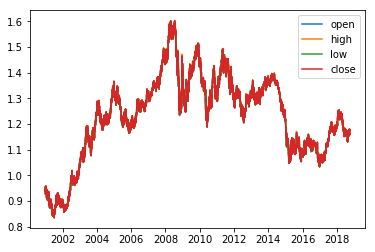

In [66]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1.csv',sep=';', reindex_fillna=True, plot_it=True)    

# visualizo una sección
trace = go.Candlestick(x=df.index[-100:],
                               open=df.OPEN[-100:],
                               high=df.HIGH[-100:],
                               low=df.LOW[-100:],
                               close=df.CLOSE[-100:])
data = [trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=700,    
    title='Mostrando últimos 100 datos',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

#####  Elaboración de indicadores técnicos sintéticos

A partir de los datos OHLC, y la librería TA-Lib genero diversos indicadores sintéticos, todos ellos aplicados a los precios <high> y <low>:

- bollWidthRel: Aporta la anchura de las bandas bollinger relativa a su propia SMA100
- bollR: Aporta la posición del precio en relación a la banda bollinger en %
- atr: Aporta la diferencia entre éste y el cierre de la sesión anterior
- SMAx3: Aporta una medida de la tendencia de corto-medio-alto plazo
- Además también puedo añadir los precios aplicados <high> y <low>

,bollWidthRel_HIGH,bollR_HIGH,atr_HIGH,SMAx3_HIGH,bollWidthRel_LOW,bollR_LOW,atr_LOW,SMAx3_LOW,HIGH,LOW
2001-01-05 03:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.9551,0.9532
2001-01-05 04:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.9553,0.9532
2001-01-05 05:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.9580,0.9541
2001-01-05 06:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.9575,0.9549
2001-01-05 07:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.9571,0.9538


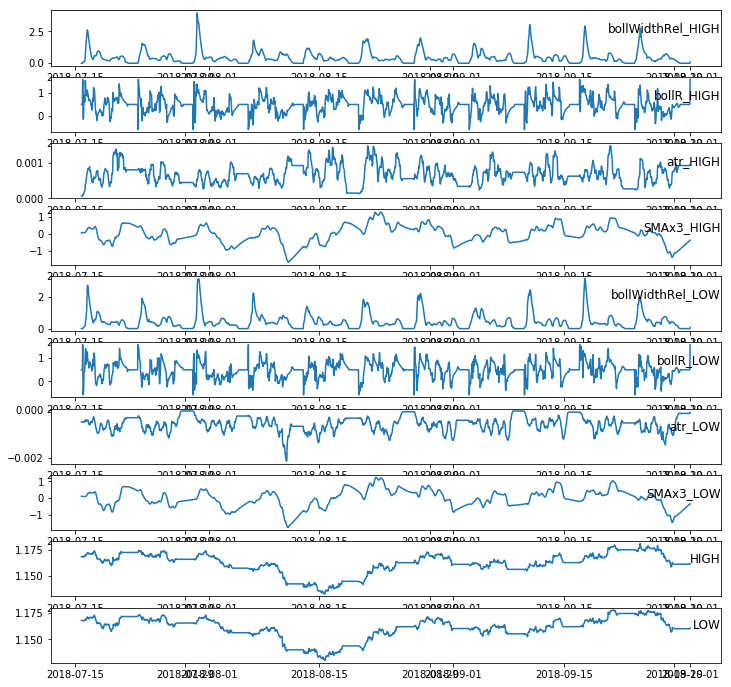

In [67]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, applied, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    cols = list()
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        sma8 = talib.SMA(df[p], timeperiod=8)
        sma50 = talib.SMA(df[p], timeperiod=50)
        sma100 = talib.SMA(df[p], timeperiod=100)    
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                sma8_50 = ((sma8/sma50)-1)/np.mean(bollinger_width)
                sma50_100 = ((sma50/sma100)-1)/np.mean(bollinger_width)
                df[i+'_'+p] = sma8_50 + sma50_100
                cols.append(i+'_'+p)
              
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))
    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df.dropna(inplace=True)    
    df = df[cols]
    if plot_it:
        plt.figure(figsize=(12,12))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(df[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    return df

####################################################################################
####################################################################################

dfapp = add_indicators(df, ['HIGH','LOW'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True, plot_it=True, starts=df.shape[0]-2000, plot_len=2000)
dfapp.head()



#####  Adaptación de los datos para realizar un entrenamiento supervisado 

Los datos vienen dados para cada timestamp, sin embargo la red neuronal espera un formato distinto, del tipo:

x: (num_samples, loopback_wdow, num_inputs)
y: (num_outputs * forecast_wdow)

En este caso, las entradas van a ser los diferentes indicadores aplicados a cada precio 'high-low' y las salidas serán esos precios 'high-low'. Se utilizarán datos de las últimas 18 sesiones y se predecirán los de las 6 siguientes. Por lo tanto: 

num_inputs = 8
num_in_steps = 18
num_outputs = 2
forecast_wdow = 6

In [68]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 18
forecast_wdow = 6
num_outputs = 2
num_inputs = dfapp.shape[1] - num_outputs
sts_df = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, forecast_wdow)
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  155399


,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,HIGH(t+1),LOW(t+1),HIGH(t+2),LOW(t+2),HIGH(t+3),LOW(t+3),HIGH(t+4),LOW(t+4),HIGH(t+5),LOW(t+5)
2001-01-05 21:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.146593,0.918537,...,0.9588,0.9574,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555
2001-01-05 22:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.168122,1.041759,...,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555
2001-01-05 23:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.178544,0.937468,...,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555
2001-01-06 00:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.189038,0.866987,...,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555
2001-01-06 01:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.206753,0.961478,...,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555,0.9584,0.9555


In [69]:
####################################################################################
# PASO 6: Crea columnas con salidas en función de valores de salida (t, t+n), con opción de borrar las salidas anteriores
def build_min_max_cols(df, **kwargs):
    df = df.copy()
    cols = list()
    drop_cols = False
    for key,val in kwargs.items():
        if key=='drop': 
            drop_cols=val
            continue
        if key=='cols_min':
            cols = val            
            df['min'] = df[cols].apply(lambda x: np.min(x), axis=1)
            continue
        if key=='cols_max':
            cols = val                    
            df['max'] = df[cols].apply(lambda x: np.max(x), axis=1)
            continue
    if drop_cols:
        df = df.drop(columns=cols_min+cols_max)
    return df

####################################################################################
####################################################################################

sts_src = build_min_max_cols(sts_df, cols_min=['LOW(t)','LOW(t+1)','LOW(t+2)','LOW(t+3)','LOW(t+4)','LOW(t+5)'], cols_max=['HIGH(t)','HIGH(t+1)','HIGH(t+2)','HIGH(t+3)','HIGH(t+4)','HIGH(t+5)'], drop=False)
print(sts_src.head())
# sts_src contiene el dataframe original sin escalado y con todas las columnas más representativas


                     bollWidthRel_HIGH(t-18)  bollR_HIGH(t-18)  \
2001-01-05 21:00:00                 0.152275          0.932599   
2001-01-05 22:00:00                 0.146593          0.918537   
2001-01-05 23:00:00                 0.168122          1.041759   
2001-01-06 00:00:00                 0.178544          0.937468   
2001-01-06 01:00:00                 0.189038          0.866987   

                     atr_HIGH(t-18)  SMAx3_HIGH(t-18)  bollWidthRel_LOW(t-18)  \
2001-01-05 21:00:00        0.001521          1.064631                0.243077   
2001-01-05 22:00:00        0.001614          1.110881                0.188026   
2001-01-05 23:00:00        0.001764          1.217782                0.197474   
2001-01-06 00:00:00        0.001750          1.321879                0.209365   
2001-01-06 01:00:00        0.001807          1.398634                0.216810   

                     bollR_LOW(t-18)  atr_LOW(t-18)  SMAx3_LOW(t-18)  \
2001-01-05 21:00:00         0.883228      -0

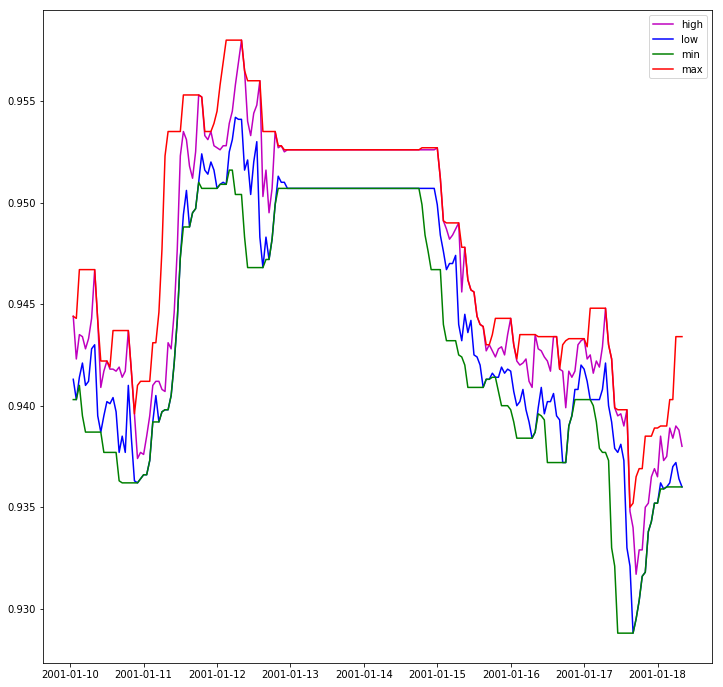

In [70]:
####################################################################################
# PASO 7: Chequeo de los datos antes de su selección y normalización para la red neuronal 
plt.figure(figsize=(12,12))
i,j=100,300
plt.plot(sts_src['HIGH(t)'][i:j],color='m')
plt.plot(sts_src['LOW(t)'][i:j],color='b')
plt.plot(sts_src['min'][i:j],color='g')
plt.plot(sts_src['max'][i:j],color='r')
plt.legend(['high','low','min','max'], loc='upper right')


In [71]:
####################################################################################
# PASO 8: Selecciono las columnas que se utilizarán en la red neuronal (para normalizarse)
sts_df = sts_src.copy()
sts_df.drop(columns=['HIGH(t)','HIGH(t+1)','HIGH(t+2)','HIGH(t+3)','HIGH(t+4)','HIGH(t+5)','LOW(t)','LOW(t+1)','LOW(t+2)','LOW(t+3)','LOW(t+4)','LOW(t+5)'], inplace=True)
num_outputs = 2
num_out_steps = 1
sts_df.head()

,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,bollWidthRel_HIGH(t-1),bollR_HIGH(t-1),atr_HIGH(t-1),SMAx3_HIGH(t-1),bollWidthRel_LOW(t-1),bollR_LOW(t-1),atr_LOW(t-1),SMAx3_LOW(t-1),min,max
2001-01-05 21:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.146593,0.918537,...,0.082687,0.822300,0.001807,1.148793,0.110590,0.956448,-0.002271,0.978040,0.9555,0.9588
2001-01-05 22:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.168122,1.041759,...,0.085726,0.856584,0.001786,1.189753,0.124485,0.987752,-0.002150,1.057196,0.9555,0.9588
2001-01-05 23:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.178544,0.937468,...,0.087930,0.860352,0.001486,1.218568,0.137735,0.940902,-0.002086,1.224106,0.9555,0.9584
2001-01-06 00:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.189038,0.866987,...,0.090778,0.771910,0.001543,1.254206,0.143449,0.739540,-0.001971,1.322654,0.9555,0.9584
2001-01-06 01:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.206753,0.961478,...,0.093724,0.746247,0.001550,1.310545,0.149489,0.723822,-0.002014,1.389059,0.9555,0.9584


In [73]:
####################################################################################
# PASO 9: Creo los scalers de cada columna seleccionada
values = sts_df.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=values, columns=sts_df.columns, index=sts_df.index)
sts_values = sts_scaled.values
sts_scaled.head()


,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,bollWidthRel_HIGH(t-1),bollR_HIGH(t-1),atr_HIGH(t-1),SMAx3_HIGH(t-1),bollWidthRel_LOW(t-1),bollR_LOW(t-1),atr_LOW(t-1),SMAx3_LOW(t-1),min,max
2001-01-05 21:00:00,-0.981727,0.397491,-0.576205,-0.026875,-0.970698,0.351674,0.687408,0.045742,-0.982409,0.384614,...,-0.990078,0.296489,-0.518309,-0.011103,-0.986669,0.418866,0.525492,0.023850,-0.682844,-0.684733
2001-01-05 22:00:00,-0.982409,0.384614,-0.557389,-0.018207,-0.977334,0.387139,0.718185,0.057433,-0.979825,0.497451,...,-0.989713,0.327883,-0.522652,-0.003427,-0.984994,0.447592,0.548240,0.038625,-0.682844,-0.684733
2001-01-05 23:00:00,-0.979825,0.497451,-0.526994,0.001826,-0.976195,0.390499,0.742272,0.073116,-0.978575,0.401949,...,-0.989448,0.331333,-0.583442,0.001973,-0.983396,0.404599,0.560284,0.069779,-0.682844,-0.685778
2001-01-06 00:00:00,-0.978575,0.401949,-0.529889,0.021334,-0.974761,0.384011,0.765021,0.089887,-0.977315,0.337409,...,-0.989107,0.250345,-0.571863,0.008652,-0.982708,0.219818,0.581694,0.088173,-0.682844,-0.685778
2001-01-06 01:00:00,-0.977315,0.337409,-0.518309,0.035719,-0.973864,0.288005,0.763683,0.103696,-0.975190,0.423936,...,-0.988753,0.226846,-0.570415,0.019210,-0.981979,0.205393,0.573665,0.100568,-0.682844,-0.685778


<Figure size 432x288 with 0 Axes>

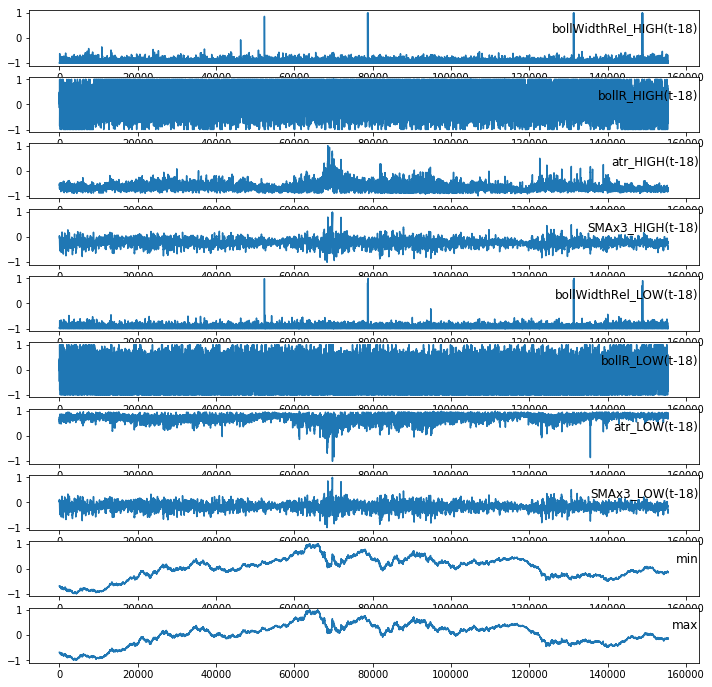

In [74]:
####################################################################################
# PASO 10 (opcional): Visualización de entradas y salidas escaladas
plt.figure()
plots = num_inputs + num_outputs
plt.figure(figsize=(12,12))
for col in range(num_inputs):
  plt.subplot(plots, 1, col+1)
  plt.plot(values[:, col])
  plt.title(sts_scaled.columns[col], y=0.5, loc='right')
for col in range(num_outputs):
  plt.subplot(plots, 1, num_inputs+col+1)
  plt.plot(values[:, -num_outputs+col])
  plt.title(sts_scaled.columns[-num_outputs+col], y=0.5, loc='right')


##### Preparación de los pares entrenamiento-validación y test

El dataframe normalizado 'sts_scaled' se divide en dos grupos:     |------ train&validate------|-- test --|
A continuación se calculan los tamaños de las ventanas de walk-forward:

|--------- wdow_train_validate ---------|
|----- wdow_train -----|-- wdow_valid --|
        |----- wdow_train -----|-- wdow_valid --|
                |----- wdow_train -----|-- wdow_valid --|
                        ...


In [83]:
# calculo el nº de muestras totales en el dataframe normalizado 'sts_scaled'
total_samples = sts_scaled.shape[0]
# divido en 2 grupos: entrenamiento-validación y otro restante que será el de test final (en modo predicción)
train_validate_samples = int(np.floor(total_samples*0.95))

# aplico el walk-forward diviendo el conjunto train-validate en un número de muestras
wdow_divisor = 100
wdow_train_validate = int(np.floor(train_validate_samples/wdow_divisor))
wdow_train = int(np.floor(wdow_train_validate * 0.8))
wdow_validate = wdow_train_validate - wdow_train
wdow_forward = wdow_validate
wdow_train_validate = wdow_train + wdow_validate
train_validate_samples = wdow_train_validate * wdow_divisor
# las muestras descartadas al redondear los porcentajes se unen al grupo de test:
test_samples = total_samples - train_validate_samples


print('Resumen:')
print('Nª de muestras totales: ___________', total_samples)
print('Nº de muestras de train-validate: _', train_validate_samples)
print('....ventana train-validate: _______', wdow_train_validate)
print('....nº de muestras train: _________', wdow_train)
print('....nº de muestras validate: ______', wdow_validate)
print('Nº de muestras de test final: _____', test_samples)


Resumen:
Nª de muestras totales: ___________ 155399
Nº de muestras de train-validate: _ 147600
....ventana train-validate: _______ 1476
....nº de muestras train: _________ 1180
....nº de muestras validate: ______ 296
Nº de muestras de test final: _____ 7799


In [86]:
####################################################################################
# PASO 11: Crea los pares de entrenamiento, test y validación
def walk_forward(values, wf_train, wf_validate, wf_forward):
    # calculo el número de muestras del walk-forward (wf_size) en base a los wf de entrenamiento y test
    wf_size = wf_train + wf_validate
    # creo arrays para obtener los conjuntos de entranamiento y validación
    nd_train=list()
    nd_validate=list()    
    # creo un bucle mientras que esté en el rango del número de muestras a procesar
    for i in range(0,values.shape[0], wf_forward):
        if i+wf_size >= values.shape[0]:
            i = values.shape[0] - wf_size
            nd_train.append(values[i:i+wf_train,:])
            nd_validate.append(values[i+wf_train:i+wf_size,:])
            break    
        else:
            nd_train.append(values[i:i+wf_train,:])
            nd_validate.append(values[i+wf_train:i+wf_size,:])
    return nd_train,nd_validate

  
####################################################################################
####################################################################################

# obtengo los grupos en formato np.ndarray
train_validate_values = sts_scaled.values[0:train_validate_samples,:]
test_values = sts_scaled.values[-test_samples:,:]

# obtengo las listas de entrenamiento-validación y el n
train,validation = walk_forward(train_validate_values, wdow_train, wdow_validate, wdow_forward) 

# formateo las listas para que tengan un shape (num_wf_groups, num_samples, num_features_xy)
train = np.asarray(train).reshape((len(train), wdow_train, train_validate_values.shape[1]))
validation = np.asarray(validation).reshape((len(validation), wdow_validate, train_validate_values.shape[1]))
test = test_values.reshape(1, test_values.shape[0], test_values.shape[1])

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:,:-(num_outputs * num_out_steps)], train[:,:,-(num_outputs * num_out_steps):]
x_validation, y_validation = validation[:,:,:-(num_outputs * num_out_steps)], validation[:,:,-(num_outputs * num_out_steps):]
x_test, y_test = test[:,:,:-(num_outputs * num_out_steps)], test[:,:,-(num_outputs * num_out_steps):]
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_validation.shape)
print('y_validation shape:', y_validation.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (495, 1180, 144)
y_train shape: (495, 1180, 2)
x_validation shape: (495, 296, 144)
y_validation shape: (495, 296, 2)
x_test shape: (1, 7799, 144)
y_test shape: (1, 7799, 2)


In [87]:
####################################################################################
# PASO 12: Crea diferentes callbacks para su ejecución durante el proceso de entrenamiento
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

####################################################################################
# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [88]:
####################################################################################
# PASO 13: Elije el archivo en el que se guardarán los pesos del modelo entrenado
file_weights = "model_weights_2610001.hdf5"

In [89]:
####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
batch_size = 16
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit.csv" updated
No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 18, 128)           70144     
_________________________________________________________________
dropout_13 (Dropout)         (None, 18, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 18, 128)           131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 18, 128)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              

In [93]:
####################################################################################
# PASO 15: Defino un control manual del número de épocas ejecutadas
epoch_count = 0

4950


--------------------
Iniciando entrenamiento en epoch= 4955
### wf(0 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.1464 - acc: 0.4695 - val_loss: 0.0047 - val_acc: 0.4932
### wf(1 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0068 - acc: 0.5186 - val_loss: 0.0040 - val_acc: 0.4628
### wf(2 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0067 - acc: 0.4915 - val_loss: 0.0119 - val_acc: 0.5203
### wf(3 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0068 - acc: 0.5059 - val_loss: 0.0075 - val_acc: 0.5169
### wf(4 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0071 - acc: 0.4873 - val_loss: 0.0038 - val_acc: 0.5270
### wf(5 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0068 - acc: 0.5085 - val_loss: 0.0011 - val_acc: 0.3682
### wf(6 de 495)
Train on 1180 samples, validate on 296 samples

### wf(55 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0019 - acc: 0.5102 - val_loss: 0.0076 - val_acc: 0.5000
### wf(56 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0031 - acc: 0.5017 - val_loss: 0.0125 - val_acc: 0.6723
### wf(57 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0029 - acc: 0.5153 - val_loss: 0.0111 - val_acc: 0.5709
### wf(58 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.4881 - val_loss: 0.0019 - val_acc: 0.5743
### wf(59 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0013 - acc: 0.5017 - val_loss: 8.9005e-04 - val_acc: 0.4527
### wf(60 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.2111e-04 - acc: 0.4949 - val_loss: 0.0022 - val_acc: 0.5000
### wf(61 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.3423e-04 - acc: 0.5

 - 2s - loss: 0.0042 - acc: 0.5492 - val_loss: 0.0128 - val_acc: 0.3682
### wf(111 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0046 - acc: 0.4619 - val_loss: 0.0225 - val_acc: 0.6250
### wf(112 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0052 - acc: 0.5034 - val_loss: 0.0131 - val_acc: 0.5709
### wf(113 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0045 - acc: 0.4534 - val_loss: 0.0110 - val_acc: 0.4088
### wf(114 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.4720 - val_loss: 0.0031 - val_acc: 0.4662
### wf(115 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0029 - acc: 0.4602 - val_loss: 0.0050 - val_acc: 0.4696
### wf(116 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0032 - acc: 0.4805 - val_loss: 0.0058 - val_acc: 0.4324
### wf(117 de 495)
Train on 1180 samples

### wf(165 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.3235e-04 - acc: 0.6449 - val_loss: 1.6163e-04 - val_acc: 0.7838
### wf(166 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 3.6039e-04 - acc: 0.6915 - val_loss: 0.0015 - val_acc: 0.7534
### wf(167 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.4383e-04 - acc: 0.7212 - val_loss: 0.0013 - val_acc: 0.7973
### wf(168 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.8800e-04 - acc: 0.7466 - val_loss: 6.3078e-04 - val_acc: 0.8142
### wf(169 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.2665e-04 - acc: 0.7864 - val_loss: 0.0019 - val_acc: 0.7736
### wf(170 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 8.3970e-04 - acc: 0.7839 - val_loss: 0.0129 - val_acc: 0.7196
### wf(171 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2

 - 2s - loss: 0.0032 - acc: 0.5059 - val_loss: 0.0021 - val_acc: 0.3412
### wf(220 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0034 - acc: 0.5305 - val_loss: 0.0052 - val_acc: 0.5878
### wf(221 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0035 - acc: 0.5551 - val_loss: 0.0539 - val_acc: 0.5743
### wf(222 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0129 - acc: 0.4754 - val_loss: 0.0424 - val_acc: 0.5743
### wf(223 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0163 - acc: 0.4805 - val_loss: 0.0474 - val_acc: 0.6622
### wf(224 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0133 - acc: 0.5610 - val_loss: 0.0046 - val_acc: 0.6520
### wf(225 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0043 - acc: 0.6220 - val_loss: 0.0323 - val_acc: 0.7297
### wf(226 de 495)
Train on 1180 samples

### wf(275 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0148 - acc: 0.6373 - val_loss: 0.0190 - val_acc: 0.5574
### wf(276 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0077 - acc: 0.6534 - val_loss: 8.6034e-04 - val_acc: 0.5811
### wf(277 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.6263 - val_loss: 0.0081 - val_acc: 0.5000
### wf(278 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0050 - acc: 0.5593 - val_loss: 0.0157 - val_acc: 0.4865
### wf(279 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0066 - acc: 0.5288 - val_loss: 0.0176 - val_acc: 0.4291
### wf(280 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0068 - acc: 0.4992 - val_loss: 0.0045 - val_acc: 0.5676
### wf(281 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0035 - acc: 0.49

 - 3s - loss: 8.0274e-04 - acc: 0.5729 - val_loss: 3.4265e-04 - val_acc: 0.6453
### wf(331 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 6.4440e-04 - acc: 0.5822 - val_loss: 0.0013 - val_acc: 0.6622
### wf(332 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 7.6555e-04 - acc: 0.6195 - val_loss: 0.0120 - val_acc: 0.4797
### wf(333 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 0.0025 - acc: 0.5805 - val_loss: 0.0227 - val_acc: 0.5473
### wf(334 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 0.0058 - acc: 0.5576 - val_loss: 0.0131 - val_acc: 0.6149
### wf(335 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 0.0053 - acc: 0.5220 - val_loss: 0.0040 - val_acc: 0.5000
### wf(336 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 3s - loss: 0.0022 - acc: 0.4881 - val_loss: 0.0050 - val_acc: 0.3919
### wf(337 de 495)
Train

### wf(385 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 2.5838e-04 - acc: 0.8034 - val_loss: 0.0017 - val_acc: 0.7703
### wf(386 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 5.6289e-04 - acc: 0.8008 - val_loss: 0.0028 - val_acc: 0.7500
### wf(387 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 9.7315e-04 - acc: 0.8110 - val_loss: 6.9469e-04 - val_acc: 0.7669
### wf(388 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 4.7235e-04 - acc: 0.7932 - val_loss: 2.2378e-04 - val_acc: 0.8514
### wf(389 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 3.5662e-04 - acc: 0.7839 - val_loss: 5.7743e-05 - val_acc: 0.9899
### wf(390 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 4s - loss: 2.5511e-04 - acc: 0.8390 - val_loss: 2.2791e-04 - val_acc: 0.7500
### wf(391 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 

 - 5s - loss: 0.0026 - acc: 0.4339 - val_loss: 2.7319e-04 - val_acc: 0.2635
### wf(440 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0025 - acc: 0.4263 - val_loss: 3.4552e-04 - val_acc: 0.5338
### wf(441 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0019 - acc: 0.4297 - val_loss: 4.0774e-04 - val_acc: 0.4730
### wf(442 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0013 - acc: 0.4729 - val_loss: 0.0017 - val_acc: 0.5304
### wf(443 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0019 - acc: 0.4695 - val_loss: 0.0028 - val_acc: 0.4358
### wf(444 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0026 - acc: 0.4814 - val_loss: 4.5672e-04 - val_acc: 0.3919
### wf(445 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 5s - loss: 0.0024 - acc: 0.4593 - val_loss: 6.6909e-04 - val_acc: 0.5169
### wf(446 de 495)
T

### wf(494 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 5.8797e-04 - acc: 0.8737 - val_loss: 0.0032 - val_acc: 0.9189

--------------------
Iniciando entrenamiento en epoch= 4956
### wf(0 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 0.0759 - acc: 0.4881 - val_loss: 0.0023 - val_acc: 0.4662
### wf(1 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 0.0039 - acc: 0.5195 - val_loss: 0.0026 - val_acc: 0.4628
### wf(2 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 0.0042 - acc: 0.5017 - val_loss: 0.0109 - val_acc: 0.5203
### wf(3 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 0.0053 - acc: 0.5085 - val_loss: 0.0053 - val_acc: 0.5169
### wf(4 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 6s - loss: 0.0058 - acc: 0.4763 - val_loss: 0.0029 - val_acc: 0.5270
### wf(5 de 495)
Train on 1180 samples, validate on 296 s

### wf(54 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0011 - acc: 0.5000 - val_loss: 0.0067 - val_acc: 0.6419
### wf(55 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0021 - acc: 0.5424 - val_loss: 0.0089 - val_acc: 0.6284
### wf(56 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0032 - acc: 0.4924 - val_loss: 0.0133 - val_acc: 0.3885
### wf(57 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0030 - acc: 0.4797 - val_loss: 0.0087 - val_acc: 0.3514
### wf(58 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0024 - acc: 0.5025 - val_loss: 0.0022 - val_acc: 0.5743
### wf(59 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 0.0013 - acc: 0.4983 - val_loss: 0.0010 - val_acc: 0.4527
### wf(60 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 7s - loss: 4.4254e-04 - acc: 0.4983 - va

 - 8s - loss: 0.0024 - acc: 0.5254 - val_loss: 0.0161 - val_acc: 0.5507
### wf(110 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0041 - acc: 0.5237 - val_loss: 0.0132 - val_acc: 0.6824
### wf(111 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0046 - acc: 0.4771 - val_loss: 0.0202 - val_acc: 0.6182
### wf(112 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0053 - acc: 0.4992 - val_loss: 0.0116 - val_acc: 0.5709
### wf(113 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0043 - acc: 0.4551 - val_loss: 0.0112 - val_acc: 0.4088
### wf(114 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0040 - acc: 0.5008 - val_loss: 0.0027 - val_acc: 0.4662
### wf(115 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 8s - loss: 0.0027 - acc: 0.4881 - val_loss: 0.0040 - val_acc: 0.4696
### wf(116 de 495)
Train on 1180 samples

 - 2s - loss: 4.9166e-04 - acc: 0.6517 - val_loss: 5.4760e-04 - val_acc: 0.6554
### wf(165 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.5597e-04 - acc: 0.6475 - val_loss: 1.3575e-04 - val_acc: 0.7838
### wf(166 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.0341e-04 - acc: 0.6915 - val_loss: 0.0014 - val_acc: 0.7534
### wf(167 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.6239e-04 - acc: 0.7212 - val_loss: 0.0013 - val_acc: 0.7973
### wf(168 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.1386e-04 - acc: 0.7466 - val_loss: 5.6769e-04 - val_acc: 0.8142
### wf(169 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.5790e-04 - acc: 0.7864 - val_loss: 0.0016 - val_acc: 0.7736
### wf(170 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 8.7145e-04 - acc: 0.7839 - val_loss: 0.0114 - val_acc: 0.7196


 - 2s - loss: 0.0036 - acc: 0.4780 - val_loss: 0.0026 - val_acc: 0.3412
### wf(220 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0034 - acc: 0.5398 - val_loss: 0.0054 - val_acc: 0.5574
### wf(221 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0033 - acc: 0.5373 - val_loss: 0.0465 - val_acc: 0.5270
### wf(222 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0117 - acc: 0.4856 - val_loss: 0.0374 - val_acc: 0.6047
### wf(223 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0152 - acc: 0.4847 - val_loss: 0.0503 - val_acc: 0.6622
### wf(224 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0120 - acc: 0.5619 - val_loss: 0.0095 - val_acc: 0.6520
### wf(225 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0045 - acc: 0.6220 - val_loss: 0.0261 - val_acc: 0.7297
### wf(226 de 495)
Train on 1180 samples

### wf(275 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0140 - acc: 0.6373 - val_loss: 0.0270 - val_acc: 0.5574
### wf(276 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0070 - acc: 0.6542 - val_loss: 0.0021 - val_acc: 0.5811
### wf(277 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0032 - acc: 0.6314 - val_loss: 0.0083 - val_acc: 0.5000
### wf(278 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5907 - val_loss: 0.0171 - val_acc: 0.4865
### wf(279 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0062 - acc: 0.5432 - val_loss: 0.0219 - val_acc: 0.4291
### wf(280 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0064 - acc: 0.5186 - val_loss: 0.0059 - val_acc: 0.5676
### wf(281 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0034 - acc: 0.4847 -

 - 2s - loss: 7.5999e-04 - acc: 0.5475 - val_loss: 2.1843e-04 - val_acc: 0.5304
### wf(331 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.8328e-04 - acc: 0.5737 - val_loss: 0.0011 - val_acc: 0.6622
### wf(332 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.7637e-04 - acc: 0.6042 - val_loss: 0.0113 - val_acc: 0.4797
### wf(333 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.5864 - val_loss: 0.0228 - val_acc: 0.5473
### wf(334 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0057 - acc: 0.5746 - val_loss: 0.0139 - val_acc: 0.5203
### wf(335 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0047 - acc: 0.5737 - val_loss: 0.0035 - val_acc: 0.5473
### wf(336 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.5263 - val_loss: 0.0036 - val_acc: 0.6115
### wf(337 de 495)
Train

### wf(385 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.8540e-04 - acc: 0.8034 - val_loss: 0.0015 - val_acc: 0.7703
### wf(386 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.5711e-04 - acc: 0.8008 - val_loss: 0.0030 - val_acc: 0.7500
### wf(387 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 9.2572e-04 - acc: 0.8110 - val_loss: 3.4958e-04 - val_acc: 0.7669
### wf(388 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.4812e-04 - acc: 0.7932 - val_loss: 2.9017e-04 - val_acc: 0.8514
### wf(389 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 3.3744e-04 - acc: 0.7839 - val_loss: 9.9063e-05 - val_acc: 0.9899
### wf(390 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.6590e-04 - acc: 0.8390 - val_loss: 1.8349e-04 - val_acc: 0.7500
### wf(391 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 

### wf(440 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.4915 - val_loss: 3.3926e-04 - val_acc: 0.5777
### wf(441 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.4407 - val_loss: 5.3219e-04 - val_acc: 0.4730
### wf(442 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0014 - acc: 0.4932 - val_loss: 0.0023 - val_acc: 0.4628
### wf(443 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0019 - acc: 0.4839 - val_loss: 0.0040 - val_acc: 0.4358
### wf(444 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.4856 - val_loss: 2.9864e-04 - val_acc: 0.3919
### wf(445 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.4483 - val_loss: 9.2006e-04 - val_acc: 0.4797
### wf(446 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0017

 - 2s - loss: 5.5985e-04 - acc: 0.8737 - val_loss: 0.0035 - val_acc: 0.9189

--------------------
Iniciando entrenamiento en epoch= 4957
### wf(0 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0801 - acc: 0.4932 - val_loss: 0.0025 - val_acc: 0.4662
### wf(1 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.5136 - val_loss: 0.0022 - val_acc: 0.4628
### wf(2 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0037 - acc: 0.5288 - val_loss: 0.0080 - val_acc: 0.5203
### wf(3 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0049 - acc: 0.5347 - val_loss: 0.0046 - val_acc: 0.4595
### wf(4 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0050 - acc: 0.5017 - val_loss: 0.0029 - val_acc: 0.5236
### wf(5 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0045 - acc: 0.5144 - val_loss: 0.0012 - val

 - 2s - loss: 0.0012 - acc: 0.5246 - val_loss: 0.0067 - val_acc: 0.4223
### wf(55 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0021 - acc: 0.5153 - val_loss: 0.0090 - val_acc: 0.4662
### wf(56 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0033 - acc: 0.5000 - val_loss: 0.0129 - val_acc: 0.3919
### wf(57 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0030 - acc: 0.4814 - val_loss: 0.0104 - val_acc: 0.5709
### wf(58 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0025 - acc: 0.4958 - val_loss: 0.0022 - val_acc: 0.5743
### wf(59 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0013 - acc: 0.4992 - val_loss: 0.0016 - val_acc: 0.4527
### wf(60 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.8961e-04 - acc: 0.4932 - val_loss: 0.0028 - val_acc: 0.5000
### wf(61 de 495)
Train on 1180 samples, v

### wf(110 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5576 - val_loss: 0.0143 - val_acc: 0.3682
### wf(111 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0043 - acc: 0.4695 - val_loss: 0.0260 - val_acc: 0.4696
### wf(112 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0049 - acc: 0.5102 - val_loss: 0.0128 - val_acc: 0.5709
### wf(113 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0041 - acc: 0.4780 - val_loss: 0.0140 - val_acc: 0.4088
### wf(114 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.4890 - val_loss: 0.0036 - val_acc: 0.4662
### wf(115 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.4949 - val_loss: 0.0050 - val_acc: 0.4696
### wf(116 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0028 - acc: 0.4822 -

### wf(165 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.0561e-04 - acc: 0.6441 - val_loss: 7.3443e-05 - val_acc: 0.7838
### wf(166 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.3798e-04 - acc: 0.6915 - val_loss: 0.0013 - val_acc: 0.7534
### wf(167 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.1497e-04 - acc: 0.7212 - val_loss: 0.0011 - val_acc: 0.7973
### wf(168 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.4270e-04 - acc: 0.7466 - val_loss: 8.2366e-04 - val_acc: 0.8142
### wf(169 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.0483e-04 - acc: 0.7864 - val_loss: 0.0021 - val_acc: 0.7736
### wf(170 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 9.1804e-04 - acc: 0.7839 - val_loss: 0.0138 - val_acc: 0.7196
### wf(171 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2

### wf(220 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5441 - val_loss: 0.0065 - val_acc: 0.5878
### wf(221 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5305 - val_loss: 0.0482 - val_acc: 0.4324
### wf(222 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0124 - acc: 0.5076 - val_loss: 0.0377 - val_acc: 0.6047
### wf(223 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0144 - acc: 0.4975 - val_loss: 0.0241 - val_acc: 0.6622
### wf(224 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0097 - acc: 0.5619 - val_loss: 0.0130 - val_acc: 0.6520
### wf(225 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0051 - acc: 0.6220 - val_loss: 0.0310 - val_acc: 0.7297
### wf(226 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0074 - acc: 0.6644 -

 - 2s - loss: 0.0130 - acc: 0.6373 - val_loss: 0.0372 - val_acc: 0.5574
### wf(276 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0071 - acc: 0.6534 - val_loss: 5.2849e-04 - val_acc: 0.5811
### wf(277 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0025 - acc: 0.6263 - val_loss: 0.0109 - val_acc: 0.5000
### wf(278 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0041 - acc: 0.5559 - val_loss: 0.0233 - val_acc: 0.4865
### wf(279 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0059 - acc: 0.5373 - val_loss: 0.0244 - val_acc: 0.4291
### wf(280 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0064 - acc: 0.5076 - val_loss: 0.0037 - val_acc: 0.5676
### wf(281 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0029 - acc: 0.5034 - val_loss: 0.0024 - val_acc: 0.5304
### wf(282 de 495)
Train on 1180 sam

 - 2s - loss: 7.2126e-04 - acc: 0.5568 - val_loss: 2.1624e-04 - val_acc: 0.6453
### wf(331 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.6063e-04 - acc: 0.5822 - val_loss: 0.0011 - val_acc: 0.6723
### wf(332 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 7.2689e-04 - acc: 0.6136 - val_loss: 0.0100 - val_acc: 0.4797
### wf(333 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0022 - acc: 0.5907 - val_loss: 0.0217 - val_acc: 0.5473
### wf(334 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0054 - acc: 0.5576 - val_loss: 0.0106 - val_acc: 0.5135
### wf(335 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.5542 - val_loss: 0.0033 - val_acc: 0.5270
### wf(336 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.5093 - val_loss: 0.0031 - val_acc: 0.5473
### wf(337 de 495)
Train

### wf(385 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.7442e-04 - acc: 0.8034 - val_loss: 0.0018 - val_acc: 0.7703
### wf(386 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.6208e-04 - acc: 0.8008 - val_loss: 0.0037 - val_acc: 0.7500
### wf(387 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 9.9572e-04 - acc: 0.8110 - val_loss: 5.6302e-04 - val_acc: 0.7669
### wf(388 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.7679e-04 - acc: 0.7932 - val_loss: 2.2862e-04 - val_acc: 0.8514
### wf(389 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 3.5270e-04 - acc: 0.7839 - val_loss: 7.6173e-05 - val_acc: 0.9899
### wf(390 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.6079e-04 - acc: 0.8390 - val_loss: 2.3099e-04 - val_acc: 0.7500
### wf(391 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 

### wf(440 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0022 - acc: 0.4847 - val_loss: 3.7391e-04 - val_acc: 0.6115
### wf(441 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0017 - acc: 0.4958 - val_loss: 2.1274e-04 - val_acc: 0.4493
### wf(442 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0014 - acc: 0.5042 - val_loss: 0.0030 - val_acc: 0.5405
### wf(443 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.4847 - val_loss: 0.0059 - val_acc: 0.4527
### wf(444 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.4890 - val_loss: 2.3994e-04 - val_acc: 0.3919
### wf(445 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0022 - acc: 0.4712 - val_loss: 8.8324e-04 - val_acc: 0.4764
### wf(446 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0017

 - 2s - loss: 5.3191e-04 - acc: 0.8737 - val_loss: 0.0028 - val_acc: 0.9189

--------------------
Iniciando entrenamiento en epoch= 4958
### wf(0 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0752 - acc: 0.4839 - val_loss: 0.0018 - val_acc: 0.4662
### wf(1 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0038 - acc: 0.5102 - val_loss: 0.0028 - val_acc: 0.4628
### wf(2 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0037 - acc: 0.5000 - val_loss: 0.0063 - val_acc: 0.5203
### wf(3 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0050 - acc: 0.5186 - val_loss: 0.0044 - val_acc: 0.5169
### wf(4 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0050 - acc: 0.5025 - val_loss: 0.0022 - val_acc: 0.6486
### wf(5 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0046 - acc: 0.5178 - val_loss: 3.0796e-04 -

 - 2s - loss: 0.0013 - acc: 0.5203 - val_loss: 0.0056 - val_acc: 0.4223
### wf(55 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0021 - acc: 0.5254 - val_loss: 0.0068 - val_acc: 0.5608
### wf(56 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0032 - acc: 0.4610 - val_loss: 0.0110 - val_acc: 0.7331
### wf(57 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0028 - acc: 0.4534 - val_loss: 0.0078 - val_acc: 0.5709
### wf(58 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0024 - acc: 0.4703 - val_loss: 0.0021 - val_acc: 0.5743
### wf(59 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0014 - acc: 0.5042 - val_loss: 0.0013 - val_acc: 0.4527
### wf(60 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.1921e-04 - acc: 0.4958 - val_loss: 0.0022 - val_acc: 0.5000
### wf(61 de 495)
Train on 1180 samples, v

### wf(110 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.5305 - val_loss: 0.0147 - val_acc: 0.4358
### wf(111 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.4780 - val_loss: 0.0269 - val_acc: 0.5304
### wf(112 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0053 - acc: 0.5017 - val_loss: 0.0123 - val_acc: 0.5709
### wf(113 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.4788 - val_loss: 0.0096 - val_acc: 0.4088
### wf(114 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0037 - acc: 0.4771 - val_loss: 0.0032 - val_acc: 0.4662
### wf(115 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0026 - acc: 0.4924 - val_loss: 0.0061 - val_acc: 0.4696
### wf(116 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0034 - acc: 0.4975 -

 - 2s - loss: 5.1553e-04 - acc: 0.6610 - val_loss: 4.9776e-04 - val_acc: 0.5676
### wf(165 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.4985e-04 - acc: 0.6381 - val_loss: 1.6831e-04 - val_acc: 0.7838
### wf(166 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.4837e-04 - acc: 0.6907 - val_loss: 0.0015 - val_acc: 0.7534
### wf(167 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.9839e-04 - acc: 0.7212 - val_loss: 9.2212e-04 - val_acc: 0.7973
### wf(168 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.2922e-04 - acc: 0.7466 - val_loss: 6.8694e-04 - val_acc: 0.8142
### wf(169 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.9508e-04 - acc: 0.7864 - val_loss: 0.0024 - val_acc: 0.7736
### wf(170 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 8.9135e-04 - acc: 0.7839 - val_loss: 0.0119 - val_acc: 0.7

 - 2s - loss: 0.0039 - acc: 0.4839 - val_loss: 0.0020 - val_acc: 0.3412
### wf(220 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.5212 - val_loss: 0.0044 - val_acc: 0.4088
### wf(221 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.5136 - val_loss: 0.0496 - val_acc: 0.3784
### wf(222 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0121 - acc: 0.5153 - val_loss: 0.0340 - val_acc: 0.6047
### wf(223 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0135 - acc: 0.5025 - val_loss: 0.0206 - val_acc: 0.6622
### wf(224 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0096 - acc: 0.5610 - val_loss: 0.0106 - val_acc: 0.6520
### wf(225 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0052 - acc: 0.6220 - val_loss: 0.0330 - val_acc: 0.7297
### wf(226 de 495)
Train on 1180 samples

### wf(275 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0111 - acc: 0.6373 - val_loss: 0.0325 - val_acc: 0.5574
### wf(276 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0059 - acc: 0.6542 - val_loss: 0.0030 - val_acc: 0.5811
### wf(277 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.6263 - val_loss: 0.0079 - val_acc: 0.5000
### wf(278 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0034 - acc: 0.5644 - val_loss: 0.0173 - val_acc: 0.4865
### wf(279 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0058 - acc: 0.5212 - val_loss: 0.0198 - val_acc: 0.4291
### wf(280 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0060 - acc: 0.5059 - val_loss: 0.0059 - val_acc: 0.5676
### wf(281 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0028 - acc: 0.5102 -

### wf(330 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.9774e-04 - acc: 0.5771 - val_loss: 3.3783e-04 - val_acc: 0.6453
### wf(331 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.0558e-04 - acc: 0.5424 - val_loss: 0.0015 - val_acc: 0.6723
### wf(332 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.8310e-04 - acc: 0.6161 - val_loss: 0.0115 - val_acc: 0.4797
### wf(333 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0022 - acc: 0.5924 - val_loss: 0.0228 - val_acc: 0.5473
### wf(334 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0057 - acc: 0.5568 - val_loss: 0.0129 - val_acc: 0.5405
### wf(335 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0049 - acc: 0.5237 - val_loss: 0.0031 - val_acc: 0.5101
### wf(336 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0016

 - 2s - loss: 3.5297e-04 - acc: 0.7703 - val_loss: 5.0143e-04 - val_acc: 0.8750
### wf(385 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.7437e-04 - acc: 0.8034 - val_loss: 0.0018 - val_acc: 0.7703
### wf(386 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.9103e-04 - acc: 0.8008 - val_loss: 0.0030 - val_acc: 0.7500
### wf(387 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 9.5180e-04 - acc: 0.8110 - val_loss: 4.3574e-04 - val_acc: 0.7669
### wf(388 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.7159e-04 - acc: 0.7932 - val_loss: 2.9021e-04 - val_acc: 0.8514
### wf(389 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 3.3957e-04 - acc: 0.7839 - val_loss: 1.0470e-04 - val_acc: 0.9899
### wf(390 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.5378e-04 - acc: 0.8390 - val_loss: 1.9362e-04 - val_acc:

 - 2s - loss: 0.0025 - acc: 0.4636 - val_loss: 3.9721e-04 - val_acc: 0.2432
### wf(440 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.5042 - val_loss: 7.2570e-04 - val_acc: 0.5338
### wf(441 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0020 - acc: 0.4627 - val_loss: 5.4695e-04 - val_acc: 0.4662
### wf(442 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0014 - acc: 0.5169 - val_loss: 0.0018 - val_acc: 0.4797
### wf(443 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0019 - acc: 0.4992 - val_loss: 0.0034 - val_acc: 0.4358
### wf(444 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0029 - acc: 0.4992 - val_loss: 6.6988e-04 - val_acc: 0.3919
### wf(445 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0025 - acc: 0.4814 - val_loss: 6.3854e-04 - val_acc: 0.4764
### wf(446 de 495)
T

### wf(494 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.2873e-04 - acc: 0.8737 - val_loss: 0.0026 - val_acc: 0.9189

--------------------
Iniciando entrenamiento en epoch= 4959
### wf(0 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0694 - acc: 0.4636 - val_loss: 0.0018 - val_acc: 0.4797
### wf(1 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5008 - val_loss: 0.0023 - val_acc: 0.4628
### wf(2 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0041 - acc: 0.4941 - val_loss: 0.0084 - val_acc: 0.5203
### wf(3 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0051 - acc: 0.5195 - val_loss: 0.0049 - val_acc: 0.4966
### wf(4 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0053 - acc: 0.4847 - val_loss: 0.0017 - val_acc: 0.5338
### wf(5 de 495)
Train on 1180 samples, validate on 296 s

### wf(54 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0014 - acc: 0.5102 - val_loss: 0.0059 - val_acc: 0.4797
### wf(55 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.5322 - val_loss: 0.0068 - val_acc: 0.5709
### wf(56 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0033 - acc: 0.4915 - val_loss: 0.0120 - val_acc: 0.5439
### wf(57 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0032 - acc: 0.5305 - val_loss: 0.0082 - val_acc: 0.5405
### wf(58 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0024 - acc: 0.5246 - val_loss: 0.0017 - val_acc: 0.5743
### wf(59 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0013 - acc: 0.5008 - val_loss: 0.0011 - val_acc: 0.4527
### wf(60 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.5663e-04 - acc: 0.5068 - va

 - 2s - loss: 0.0024 - acc: 0.5203 - val_loss: 0.0162 - val_acc: 0.6486
### wf(110 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.5314 - val_loss: 0.0142 - val_acc: 0.6284
### wf(111 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0042 - acc: 0.5212 - val_loss: 0.0285 - val_acc: 0.5980
### wf(112 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0057 - acc: 0.4907 - val_loss: 0.0109 - val_acc: 0.5709
### wf(113 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0041 - acc: 0.4788 - val_loss: 0.0101 - val_acc: 0.5541
### wf(114 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.4864 - val_loss: 0.0034 - val_acc: 0.4662
### wf(115 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0026 - acc: 0.4907 - val_loss: 0.0057 - val_acc: 0.4628
### wf(116 de 495)
Train on 1180 samples

 - 2s - loss: 5.5485e-04 - acc: 0.6322 - val_loss: 3.9816e-04 - val_acc: 0.6554
### wf(165 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.8032e-04 - acc: 0.6254 - val_loss: 1.5047e-04 - val_acc: 0.7838
### wf(166 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.3740e-04 - acc: 0.6941 - val_loss: 0.0011 - val_acc: 0.7534
### wf(167 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.5640e-04 - acc: 0.7195 - val_loss: 0.0017 - val_acc: 0.7973
### wf(168 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.4240e-04 - acc: 0.7475 - val_loss: 6.4627e-04 - val_acc: 0.8142
### wf(169 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.9138e-04 - acc: 0.7864 - val_loss: 0.0022 - val_acc: 0.7736
### wf(170 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 8.9757e-04 - acc: 0.7839 - val_loss: 0.0126 - val_acc: 0.7196


 - 2s - loss: 0.0037 - acc: 0.4788 - val_loss: 0.0019 - val_acc: 0.3784
### wf(220 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0037 - acc: 0.5203 - val_loss: 0.0062 - val_acc: 0.4628
### wf(221 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0040 - acc: 0.5220 - val_loss: 0.0509 - val_acc: 0.5845
### wf(222 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0125 - acc: 0.5042 - val_loss: 0.0396 - val_acc: 0.6047
### wf(223 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0150 - acc: 0.5042 - val_loss: 0.0362 - val_acc: 0.6622
### wf(224 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0117 - acc: 0.5627 - val_loss: 0.0061 - val_acc: 0.6520
### wf(225 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0050 - acc: 0.6220 - val_loss: 0.0320 - val_acc: 0.7297
### wf(226 de 495)
Train on 1180 samples

### wf(275 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0132 - acc: 0.6381 - val_loss: 0.0295 - val_acc: 0.5574
### wf(276 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0070 - acc: 0.6534 - val_loss: 0.0027 - val_acc: 0.5811
### wf(277 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0035 - acc: 0.6263 - val_loss: 0.0079 - val_acc: 0.5000
### wf(278 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0039 - acc: 0.5678 - val_loss: 0.0231 - val_acc: 0.4932
### wf(279 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0066 - acc: 0.5280 - val_loss: 0.0242 - val_acc: 0.4966
### wf(280 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0068 - acc: 0.5085 - val_loss: 0.0044 - val_acc: 0.5676
### wf(281 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0032 - acc: 0.5144 -

 - 2s - loss: 7.0573e-04 - acc: 0.5720 - val_loss: 2.1462e-04 - val_acc: 0.6318
### wf(331 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.2197e-04 - acc: 0.5729 - val_loss: 0.0010 - val_acc: 0.6723
### wf(332 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.6231e-04 - acc: 0.6220 - val_loss: 0.0114 - val_acc: 0.4797
### wf(333 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.5924 - val_loss: 0.0198 - val_acc: 0.5473
### wf(334 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0056 - acc: 0.5780 - val_loss: 0.0131 - val_acc: 0.5270
### wf(335 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0046 - acc: 0.5390 - val_loss: 0.0033 - val_acc: 0.4932
### wf(336 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.5042 - val_loss: 0.0028 - val_acc: 0.3818
### wf(337 de 495)
Train

### wf(385 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 3.0420e-04 - acc: 0.8034 - val_loss: 0.0018 - val_acc: 0.7703
### wf(386 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 6.2073e-04 - acc: 0.8008 - val_loss: 0.0036 - val_acc: 0.7500
### wf(387 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0011 - acc: 0.8110 - val_loss: 3.6836e-04 - val_acc: 0.7669
### wf(388 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 5.0422e-04 - acc: 0.7932 - val_loss: 2.9403e-04 - val_acc: 0.8514
### wf(389 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 4.2203e-04 - acc: 0.7839 - val_loss: 1.1485e-04 - val_acc: 0.9899
### wf(390 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 2.8824e-04 - acc: 0.8390 - val_loss: 2.4898e-04 - val_acc: 0.7500
### wf(391 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1


### wf(440 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0023 - acc: 0.4610 - val_loss: 2.0489e-04 - val_acc: 0.5338
### wf(441 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0019 - acc: 0.4364 - val_loss: 1.6740e-04 - val_acc: 0.4730
### wf(442 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0013 - acc: 0.4983 - val_loss: 0.0030 - val_acc: 0.4696
### wf(443 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - acc: 0.4754 - val_loss: 0.0049 - val_acc: 0.4358
### wf(444 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0027 - acc: 0.4763 - val_loss: 2.8245e-04 - val_acc: 0.3919
### wf(445 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0022 - acc: 0.4492 - val_loss: 0.0011 - val_acc: 0.4764
### wf(446 de 495)
Train on 1180 samples, validate on 296 samples
Epoch 1/1
 - 2s - loss: 0.0018 - a

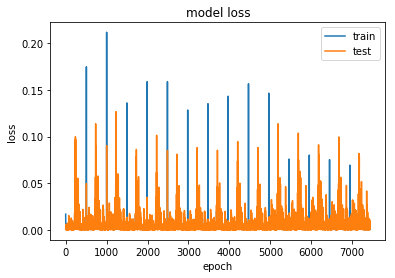

In [95]:
####################################################################################
# PASO 16: Realiza el entrenamiento de la red
num_epochs = 5
nb_epoch = 1
  
try:
  # ejecuta cada 'nb_epoch' hasta un total de 'num_epochs'
  for i in range(0, num_epochs, nb_epoch):        
    print('\r\n--------------------\r\nIniciando entrenamiento en epoch=',epoch_count)
    # ejecuta para cada grupo del walk-forward
    wf_groups = x_train.shape[0]
    for g in range(wf_groups):
      print('### wf({} de {})'.format(g, wf_groups))
      # formateo los pares x-y para compatibilizarlos con la entrada-salida de la red LSTM (num_samples, num_tsteps, num_features)
      train_x = x_train[g,:,:].reshape(x_train.shape[1], num_in_steps, num_inputs)
      train_y = y_train[g,:,:].reshape(y_train.shape[1], num_out_steps * num_outputs)
      validation_x = x_validation[g,:,:].reshape(x_validation.shape[1], num_in_steps, num_inputs)
      validation_y = y_validation[g,:,:].reshape(y_validation.shape[1], num_out_steps * num_outputs)
      history = model.fit(train_x, train_y, epochs=nb_epoch, batch_size=batch_size, callbacks=callbacks_list, validation_data=(validation_x,validation_y), verbose=2, shuffle=True) 
    # una vez que se procese todo el walk-forward, incrementaré 'num_epochs' en nb_epoch
    epoch_count += nb_epoch
except:
  print('Model fit Exception:', sys.exc_info()[0])


if ENABLE_GOOGLE_COLAB:
  files.download(file_weights)

# visualizo el resultado de la ejecución de la celda actual
plt.plot(callbacks_list[1].loss[:])
plt.plot(callbacks_list[1].val_loss[:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

  


In [97]:
# Evalúa el funcionamiento con la partición de test
test_x = x_test[0,:,:].reshape(x_test.shape[1], num_in_steps, num_inputs)
test_y = y_test[0,:,:].reshape(y_test.shape[1], num_out_steps * num_outputs)            
scores = model.evaluate(test_x, test_y, verbose=2)
print('Model Loss: ', scores[0])  
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Loss:  0.006720313151258908
Model Accuracy: 82.50%


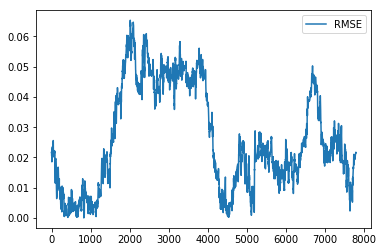

In [98]:
import math

x_data = test_x
y_data = test_y

rmse = list()
for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    rmse_val = math.sqrt(sk.mean_squared_error(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
    rmse.append(rmse_val)
    #print('RMSE: %f' % rmse_val)

plt.plot(np.asarray(rmse))    
plt.legend(['RMSE'])


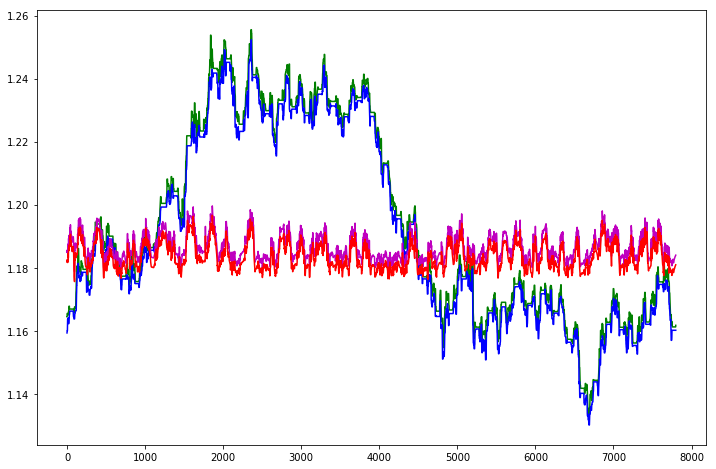

In [118]:
# visualizo las predicciones para una muestra cualquiera (a partir de num_in_steps) para poder verlo bien
x_data = test_x
y_data = test_y

target_max,target_min,forecast_max,forecast_min = list(),list(),list(),list()

for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # agrego las predicciones a la lista
    forecast_min.append(xyhat_values[0,-(num_outputs * num_out_steps)])
    forecast_max.append(xyhat_values[0,-(num_outputs * num_out_steps)+1])

    # agrego los target a la lista
    target_min.append(xy_values[0,-(num_outputs * num_out_steps)])
    target_max.append(xy_values[0,-(num_outputs * num_out_steps)+1])

# Primero visualizo los datos de entrada: tomo "al menos" los últimos num_in_steps valores de y_data y el objetivo (siguiente)
plt.figure(figsize=(12,8))
plt.plot(np.asarray(target_max).reshape((len(target_max),)),color='g')
plt.plot(np.asarray(target_min).reshape((len(target_min),)),color='b')
# A continuación visualizo la predicción, como dos rayas (roja-magenta) 
plt.plot(np.asarray(forecast_max).reshape((len(forecast_max),)),color='m')
plt.plot(np.asarray(forecast_min).reshape((len(forecast_min),)),color='r')
